# Generating 3D structures using ligand-based methods
----
<font size="3">
    
So far, we have worked on 2D molecules (as SMILES), but if we want to better understand our candidates and select the most promising ones, we need to generate 3D conformations for those SMILES.
<br><br>
There are many approaches for generating 3D conformations from the SMILES (e.g. constrained docking algorithms). In this notebook we will compute them using a ligand-based alignment and scoring routine. We assume that elaborations to the initial hit will not introduce massive changes to the binding mode, and that interactions seen in the initial hit protein-ligand complex will be conserved.
    
By default, 100 conformations of the new molecule will be calculated using the rdkit ETKDG conformation generation algorithm (Riniker & Landrum, 2015). These conformations will be then aligned to the reference hit molecule using Open3DAlign (O3A) (Tosco et al., 2011) also implemented in rdkit. In order to select which aligned conformation of the new molecule best fits with the reference molecule, we will use the SuCOS metric (Leung et al., 2019)). The SuCOS metric uses rdkit functions to calculate both the shape overlap and the chemical feature overlap between the elaborated molecule and the original fragment.
    
An implementation of this pipeline is shown in the next cell, where the main function is ``gen_conf_from_vector(input_mol_block, elaborated_smiles)`` where ``input_mol_block`` is the mol block from the reference structure, and ``elaborated_smiles`` is the smiles string of the molecule you want to calculate a predicted structure for.

</font>

----
Refs:

- Riniker, S. & Landrum, G. A. (2015). Journal of Chemical Information and Modeling. 55, 2562–2574.
- Tosco, P., Balle, T. & Shiri, F. (2011). Journal of Computer-Aided Molecular Design. 25, 777–783
- Leung, S., Bodkin, M., von Delft, F., Brennan, P. & Morris, G. (2019) https://doi.org/10.26434/chemrxiv.8100203.v1.

In [3]:
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit import RDConfig

########################################################################################
#
#  SuCOS Implementation
#
########################################################################################

fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


def get_FeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.Best):
    featLists = []
    for m in [small_m, large_m]:
        rawFeats = fdef.GetFeaturesForMol(m)
        # filter that list down to only include the ones we're intereted in
        featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    fms[0].scoreMode = score_mode
    fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
    return fm_score


def score(reflig, prb_mols, ids, score_mode=FeatMaps.FeatMapScoreMode.All, p=False):
    ref = Chem.AddHs(reflig)
    idx = 0

    results_sucos = {}
    results_tani = {}

    smi_mol = Chem.MolToSmiles(prb_mols)

    for i in ids:

        prb = Chem.AddHs(Chem.MolFromMolBlock(Chem.MolToMolBlock(prb_mols, confId=i)))

        fm_score = get_FeatureMapScore(ref, prb, score_mode)
        fm_score = np.clip(fm_score, 0, 1)

        protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
                                                         allowReordering=False)
        protrude_dist = np.clip(protrude_dist, 0, 1)

        SuCOS_score = 0.5 * fm_score + 0.5 * (1 - protrude_dist)
        tanimoto_score = Chem.rdShapeHelpers.ShapeTanimotoDist(ref, prb)

        results_sucos[str(idx)] = SuCOS_score
        results_tani[str(idx)] = tanimoto_score

        if p:
            print("********************************")
            print("index: " + str(idx))
            print("SuCOS score:\t%f" % SuCOS_score)
            print("Tani score:\t%f" % tanimoto_score)
            print("********************************")

        idx += 1

    return results_sucos


########################################################################################
#
#  Alignment & scoring implementation
#
########################################################################################

def get_best_align(hit_mblock, elab_smiles):
    hit_mol = Chem.MolFromMolBlock(hit_mblock)
    elab_mol = Chem.MolFromSmiles(elab_smiles)
    ids = AllChem.EmbedMultipleConfs(elab_mol, numConfs=100, params=AllChem.ETKDG())

    for cid in ids:
        o3d = Chem.rdMolAlign.GetO3A(prbMol=elab_mol, refMol=hit_mol, prbCid=cid)
        o3d.Align()

    results_sucos = score(hit_mol, elab_mol, ids)
    best_i = list(results_sucos.values()).index(max(results_sucos.values()))
    elab_molblock = Chem.MolToMolBlock(elab_mol, confId=best_i)

    return elab_molblock


def gen_conf_from_vector(input_mol_block, elaborated_smiles):
    # Get the mol
    m = get_best_align(input_mol_block, elaborated_smiles)
    return m

## Exercise
----
1. Use the ``gen_conf_from_vector`` function to generate a 3D conformation for each of the molecules you calculated in the Fragment Network exercise (2nd).
2. Save these out to a new sdf file
3. Generate a new sdf file combining the results from this exercise and the merging exercise.

In [4]:
# write your code here

import pandas as pd
df = pd.read_csv('mergers/elaborations.csv')
df.head()

,initial_hit,elaboration_smiles
0,Mpro-x2912_0A:TRY-UNI-714a760b-22,Cn1nnc(NC(=O)Cn2ccc3ccc(Cl)cc32)n1
1,Mpro-x2912_0A:TRY-UNI-714a760b-22,Cn1ccc(NC(=O)Cn2ccc3ccc(Cl)cc32)n1
2,Mpro-x2912_0A:TRY-UNI-714a760b-22,Cn1cc(NC(=O)Cn2ccc3ccc(Cl)cc32)cn1
3,Mpro-x2912_0A:TRY-UNI-714a760b-22,Cc1noc(NC(=O)Cn2ccc3ccc(Cl)cc32)n1
4,Mpro-x2912_0A:TRY-UNI-714a760b-22,Cc1nnc(NC(=O)Cn2ccc3ccc(Cl)cc32)s1


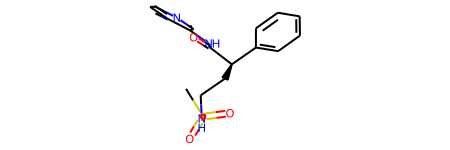

In [8]:
aminopyridine_mols = Chem.SDMolSupplier('mergers/aminopyradine_mols.sdf')
aminopyridine_mols[0]

In [11]:
elaborations = df['elaboration_smiles'].tolist()
inspirational_frags = df['initial_hit'].tolist()

inspirational_frags_mols = []

for insp in inspirational_frags:
    for mol in aminopyridine_mols:
        name = mol.GetProp('label')
        if insp == name:
            inspirational_frags_mols.append(mol)

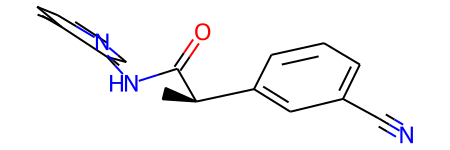

In [13]:
inspirational_frags_mols[0]

In [17]:
from rdkit.Chem import rdmolfiles
# do this for all the elaborations
conformer = gen_conf_from_vector(rdmolfiles.MolToMolBlock(inspirational_frags_mols[0]), elaborations[0])

RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not ha

RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:22] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:22] Molecule does not ha

[13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
[13:48:23] Molecule does not have explicit Hs. Consider calling AddHs()
RDKit WARNING: [13:48:23] Molecule does not have explicit Hs.

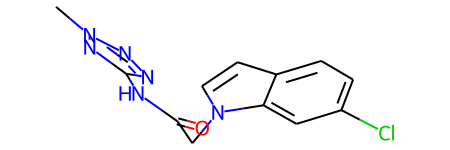

In [19]:
rdmolfiles.MolFromMolBlock(conformer)

## Constrained embedding

The above code generates random conformers and then scores them according to their overlap with the fragments. However, a smarter approach is to apply constraints to generate conformations that reflect the binding pose of the original fragments.

RDKit has a function for constrained embedding, which generates conformations where the positions of certain atoms can be constrained according to their coordinates in a reference molecule. You can read more about this function in the following blogpost: http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html.

## Exercise
----
For this exercise, we will use constrained embedding to generate conformers for elaborations of fragment x2646_0A. Some elaborations have already been generated and can be found in the sdf file ``mergers/x2646_elaborations.sdf``. The mol file for the original fragment containing the 3D coordinates can be found in ``mergers/Mpro-x2646_0A.mol``.

The code below embeds a set of molecules using coordinates from a reference fragment. It does this by calculating the maximum common substructure between the molecule to embed and the fragment, and then uses the coordinates of these atoms to constrain conformer generation for the molecule.

In [23]:
from rdkit.Chem import rdFMCS

def add_coordinates(fragment, substructure):
    """
    Function to add 3D coordinates to a substructure (e.g. MCS) from the corresponding
    atoms from the original fragment.
    """
    ref_match = fragment.GetSubstructMatch(substructure)
    rwmol = Chem.RWMol(substructure)
    rwconf = Chem.Conformer(rwmol.GetNumAtoms())  # create a conformer of the substructure
    matches = rwmol.GetSubstructMatch(substructure)  # get matches so atoms in the same order
    ref_conf = fragment.GetConformer()  # get the conformation of the actual fragment
    for i, match in enumerate(matches):  # set atom position using matching atom from fragment
        rwconf.SetAtomPosition(match, ref_conf.GetAtomPosition(ref_match[i]))
    rwmol.AddConformer(rwconf)  # add the conformation to the substructure
    return rwmol

def constrained_embedding(mols, ref_mol):
    """
    Embed elaborated molecules while constraining the positions of atoms from the original fragments using their
    3D coordinates.
    """
    embedded_mols = []

    for mol in mols:
        _ = AllChem.Compute2DCoords(mol)

        # calculates maximum common substructure (MCS) between the fragment and the elaborated compound
        mcs = rdFMCS.FindMCS([mol, ref_mol])
        mcs_mol = Chem.MolFromSmarts(mcs.smartsString)

        # add coordinates to the MCS
        core = add_coordinates(ref_mol, mcs_mol)

        nm = Chem.Mol(mol)
        nm = Chem.AddHs(nm)
        try:
            # perform constrained embedding (may fail for some molecules)
            embedded = AllChem.ConstrainedEmbed(nm, core, 42)
            AllChem.UFFOptimizeMolecule(embedded)
            embedded = Chem.RemoveHs(embedded)
            embedded_mols.append(embedded)
        except:
            pass

    return embedded_mols

1. Load the elaborated molecules and the original fragment x2646_0A from the sdf and mol files and perform constrained embedding using the function above.
2. Write the embedded molecules to a new sdf file and try visualising them in PyMOL together with the protein-ligand structure (in `mergers/Mpro-x2646_0A_bound.pdb`. Do they overlap well with the original fragment?
  - **OPTIONAL**: Try using the function below to score the molecules using the SuCOS score and ordering them according to how well they overlap with the fragment.

In [27]:
def sucos_score(reflig, prb_mols, score_mode=FeatMaps.FeatMapScoreMode.All):
    ref = Chem.AddHs(reflig)
    prb = Chem.AddHs(Chem.MolFromMolBlock(Chem.MolToMolBlock(prb_mols)))
    fm_score = get_FeatureMapScore(ref, prb, score_mode)
    fm_score = np.clip(fm_score, 0, 1)
    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
                                                     allowReordering=False)
    protrude_dist = np.clip(protrude_dist, 0, 1)
    SuCOS_score = 0.5 * fm_score + 0.5 * (1 - protrude_dist)

    return SuCOS_score

In [20]:
# write your code here
from rdkit.Chem import rdmolfiles
merges = Chem.SDMolSupplier('mergers/x2646_elaborations.sdf')
x2646 = rdmolfiles.MolFromMolFile('mergers/Mpro-x2646_0A.mol')

In [24]:
embedded_mols = constrained_embedding(merges, x2646)

RDKit WARNING: [14:29:05] Could not triangle bounds smooth molecule.
[14:29:05] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:06] Could not triangle bounds smooth molecule.
[14:29:06] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:06] Could not triangle bounds smooth molecule.
[14:29:06] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:06] Could not triangle bounds smooth molecule.
[14:29:06] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:06] Could not triangle bounds smooth molecule.
[14:29:06] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:10] Could not triangle bounds smooth molecule.
[14:29:10] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:10] Could not triangle bounds smooth molecule.
[14:29:10] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:10] Could not triangle bounds smooth molecule.
[14:29:10] Could not triangle bounds smooth molecule.
RDKit WARNING: [

RDKit WARNING: [14:29:13] Could not triangle bounds smooth molecule.
[14:29:13] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:13] Could not triangle bounds smooth molecule.
[14:29:13] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:13] Could not triangle bounds smooth molecule.
[14:29:13] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:18] Could not triangle bounds smooth molecule.
[14:29:18] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:18] Could not triangle bounds smooth molecule.
[14:29:18] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:18] Could not triangle bounds smooth molecule.
[14:29:18] Could not triangle bounds smooth molecule.
[14:29:18] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:29:18] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:29:18] UFFTYPER: Unrecognized charge state for atom: 1
[14:29:18] UFFTYPER: Unrecognized charge state for atom: 1


RDKit WARNING: [14:29:28] Could not triangle bounds smooth molecule.
[14:29:28] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:28] Could not triangle bounds smooth molecule.
[14:29:28] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:28] Could not triangle bounds smooth molecule.
[14:29:28] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:29] Could not triangle bounds smooth molecule.
[14:29:29] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:29] Could not triangle bounds smooth molecule.
[14:29:29] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:29] Could not triangle bounds smooth molecule.
[14:29:29] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:29] Could not triangle bounds smooth molecule.
[14:29:29] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:29] Could not triangle bounds smooth molecule.
[14:29:29] Could not triangle bounds smooth molecule.
RDKit WARNING: [

RDKit WARNING: [14:29:47] Could not triangle bounds smooth molecule.
[14:29:47] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:47] Could not triangle bounds smooth molecule.
[14:29:47] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:47] Could not triangle bounds smooth molecule.
[14:29:47] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:52] Could not triangle bounds smooth molecule.
[14:29:52] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:52] Could not triangle bounds smooth molecule.
[14:29:52] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:52] Could not triangle bounds smooth molecule.
[14:29:52] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:52] Could not triangle bounds smooth molecule.
[14:29:52] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:29:52] Could not triangle bounds smooth molecule.
[14:29:52] Could not triangle bounds smooth molecule.
RDKit WARNING: [

RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [14:30:00] Could not triangle bounds smooth molecule.
[14:30:00] Could not triangle bounds smooth molecule.
RDKit WARNING: [

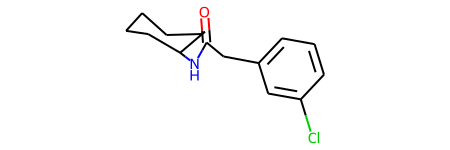

In [25]:
embedded_mols[0]

In [26]:
with Chem.SDWriter('mergers/embedded_mols.sdf') as w:
    for m in embedded_mols:
        w.write(m)

In [29]:
# to calculate the sucos score
all_sucos_scores = []
for mol in embedded_mols:
    sucos = sucos_score(x2646, mol)